In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
from scipy import stats

# Suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Disable warning
pd.options.mode.chained_assignment = None

<h3>Questions</h3>
<p>I want to get a better understanding about team budgets in the Major League Baseball (MLB). </p>
<ol>
<li>How did (adjusted) team budgets develop over time?</li>
<li>How did team budgets develop over time in the different league?</li>
<li>Is there a correlation between team experience and team budgets?</li>
<li>Is there a correlation between home attendance and team budgets?</li>
<li>Have teams that ever won the World Series higher budgets than teams never won the World Series?</li>
<li>Have teams that ever won their league higher team budgets than teams that never won their league?</li>
</ol>

<h3>Datasets</h3>
<h4>Lahman Baseball Database</h4>
<p>The Lahman Baseball Database (version 2016) contains data on players, teams, salaries and game statistics for the MLB from 1871 through 2016. This analysis uses the "Master" (player information), "Batting" (players' game statistics), "Teams" (team information) and "Salaries" (salary information) sub sets.</p> 

<h4>CPI data</h4>
<p>Data from the <a href="https://www.bls.gov/cpi/data.htm">Labour Bureau of Statistics</a> on CPI (customer price index).</p>

In [2]:
# Data from Lahman Baseball Database
salaries = pd.read_csv('Salaries.csv')
print 'Number of salaries available:', len(salaries)
master = pd.read_csv('Master.csv')
batting = pd.read_csv('Batting.csv')
teams = pd.read_csv('Teams.csv')

# Data from Labour Bureau of Statistics on CPI (customer price index) for the period 1985-2016
# Dataset is stored in Google spreadsheet
from StringIO import StringIO
import requests
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1joAHdRdXOp1ZofgcCsbSsHalliYdj0gVx5sQLHSGIJE&output=csv')
data = r.content

cpi = pd.read_csv(StringIO(data))[['Year', 'Value']]

Number of salaries available: 26428


<h3>Data preparation</h3>
<p>In order to answer the questions above, the datasets needed to be prepared by merging tables, modifying data and handle missing data.<br><br>

The Salaries dataset only has data for 1985 and onwards. For this period 26,428 salaries are available.</p>

<h4>Adjusting Salaries dataset for inflation</h4>
<p>To be able to compare salaries from different years, the salaries have to be adjusted for inflation. Doing this allows that the equivalent of salaries in 2016 dollars can be calculated. The adjusted salary data have been added to the 'Salaries' dataset.</p>

In [3]:
# Create new column with the real dollar value in 2016 prices in cpi dataset
cpi_2016 = cpi['Value'].max()
cpi['real_value'] = cpi_2016 / cpi['Value']

# Merge Salaries dataset with cpi dataset
salaries_cpi = salaries.merge(cpi, left_on='yearID', right_on='Year', how='inner')

# Create additional column for the salaries adjusted for cpi
salaries_cpi['real_salary'] = salaries_cpi['salary'] * salaries_cpi['real_value']

# Create new column in salaries_cpi that combines year, team and league ids
salaries_cpi['new']=salaries_cpi['yearID'].astype(str)+'_' + salaries_cpi['teamID'] + '_'+ salaries_cpi['lgID']

# Clean combined dataset
salaries_cpi = salaries_cpi[['yearID','teamID','lgID','playerID','salary','real_salary','new']]

<h4>Merging with Master dataset</h4>

In [4]:
# Get debut year from debut date
master['debut_year'] = pd.to_datetime(master['debut']).dt.year

# Merge salaries_cpi with Master dataset
salaries_master = salaries_cpi.merge(master[['playerID','debut_year']], on='playerID', how='left')

# Add column that calculates the experience of a player in a given year
salaries_master['experience'] = salaries_master['yearID'] - salaries_master['debut_year']

<h5>Replacing player ids</h5>
<p>For 2016 there were 8 players for which the ids from the Baseball Reference website (bbrefID) were used instead of the player ids (playerID). The incorrect ids have been replaced with the correct ones.</p>

In [5]:
# Find entries that could not be found in the Master dataset
not_in_master = salaries_master[salaries_master.debut_year.isnull()]
print 'Entries that have no match in Master dataset:', len(not_in_master)

# Match data on bbrefID instead of playerID
not_in_master = not_in_master[['yearID','teamID','lgID','playerID','salary','real_salary','new']].\
    merge(master, left_on='playerID', right_on='bbrefID', how='left')

# Rename playerID_y to playerID
not_in_master = not_in_master.rename(index=str, columns={"playerID_y": "playerID"})

# Change order of column names so that matches salaries_master
cols = list(not_in_master.columns.values)
not_in_master = not_in_master[['yearID','teamID','lgID','playerID','salary','real_salary','new','debut_year']]

# Add experience column
not_in_master['experience'] = not_in_master['yearID'] - not_in_master['debut_year']

# Drop rows with missing data from salaries_master
salaries_master_dropped = salaries_master.dropna(thresh=8)

# Add rows from not_in_master to salaries_master 
salaries_master_adj = salaries_master_dropped.append(not_in_master)
print 'Number of salaries:', len(salaries_master_adj)

Entries that have no match in Master dataset: 8
Number of salaries: 26428


<h5>Removing players with incorrect years of experience</h5>
<p>For this dataset the youngest player at their MLB debut was 18 years old. The oldest players for this dataset, were under 50 when retiring. <a href="https://en.wikipedia.org/wiki/List_of_oldest_Major_League_Baseball_players">James Moyer</a> retired in 2012 at age 49 which made that he had a career of 26 years. It was therefore assumed that players would have an experience between 0 and 30 years.<br><br>
For 48 players the years of experience did not fell between 0 and 30 years. It is assumed that in most cases the Salaries data was not assigned to the correct year. For the 3 players that had more than 30 years experience the Salaries data was assigned probabbly incorrectly assined to their player id. As the mean salary of these player was much lower that overall mean (not even 10%), it was decided to drop these 48 players.</p>

In [6]:
# Find the player's age at debut
age_debut = salaries_master_adj.merge(master, on=['playerID'])
print 'Age of youngest debut player:', (age_debut['debut_year_y'] - age_debut['birthYear']).min()

# Number of players that have less than 0 or more than 30 years experience
print 'Negative # of years / more than 30 years :', (len(salaries_master_adj[(salaries_master_adj.experience<0)]), \
    len(salaries_master_adj[(salaries_master_adj.experience>30)]))

print "Mean salary for incorrect experience vs whole dataset:", \
    ((salaries_master_adj[(salaries_master_adj.experience>30) | (salaries_master_adj.experience<0)])\
    ['real_salary'].mean() / salaries_master_adj['real_salary'].mean()).round(2)

# Drop these players
salaries_master_adj2 = salaries_master_adj[(salaries_master_adj.experience>=0) & (salaries_master_adj.experience<=30)]
print 'Number of salaries:', len(salaries_master_adj2)

Age of youngest debut player: 18.0
Negative # of years / more than 30 years : (45, 3)
Mean salary for incorrect experience vs whole dataset: 0.09
Number of salaries: 26380


<h4>Merging with Teams dataset</h4>

In [7]:
# Select only data for 1985 onwards
teams_1985 = teams[teams.yearID>=1985][['yearID','teamID','lgID','LgWin','WSWin','attendance','teamIDBR','name']]

# Team id to team name mapping
teamid_name =(teams_1985.groupby(['teamID','name','lgID'], as_index=False).count()[['teamID','name','lgID']])

# Merge salaries_master_adj with Master dataset
salaries_teams = salaries_master_adj2.merge(teams_1985, on=['yearID','teamID','lgID'], how='left')

In [8]:
# Find entries that could not be found in the Teams dataset
not_in_teams = salaries_teams[salaries_teams.LgWin.isnull()]

print not_in_teams.groupby('yearID', as_index=False).count()\
    [['yearID','teamID','LgWin','WSWin','attendance','teamIDBR']].to_string(index=False)

yearID  teamID  LgWin  WSWin  attendance  teamIDBR
  1994     884      0      0         884       884
  2014       1      0      0           0         0
  2015       1      0      0           0         0
  2016     311      0      0           0         0


<p>1,197 entries of the combined Salaries and Teams dataset have missing data.
<ul>
<li>For 1994 884 entries have missing data on if they won (yes/no) their legaue (LgWin) and the World Series (WSWin). This makes sense as a <a href="https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike">players' strike</a> took place during the 1994 season which meant that no post-season games were played. So these missing data can be explained.</li>
<li>Both 2014 and 2015 have one entry that could not be matched. This is caused by two players having been assigned the wrong league (lgID) for their team.</li>
<li>2016 has 311 entries with missing data. This is caused by the fact that incorrect team ids were used for a number of clubs.</li></ul></p>

<h5>Replacing league ids</h5>
<p>For 2 entries the team id (teamID) was assigned the wrong league id (lgID). This was corrected.</p>

In [9]:
# Find entries that have a combination of year, teamID and lgID that only occurs once
wrong_lg = salaries_teams.groupby('new', as_index=False).count()
wrong_lg = wrong_lg[wrong_lg.yearID==1]['new']

# Replace the lgID with the correct one
salaries_teams.loc[salaries_teams['new'] == '2014_CLE_NL', 'lgID'] = 'AL'
salaries_teams.loc[salaries_teams['new'] == '2015_ARI_AL', 'lgID'] = 'NL'

<h5>Replacing team ids</h5>
<p>For 2016 the team IDs used by the Baseball Reference website (teamIDBR) were used instead of the team ids (teamID) for 11 teams. The incorrect ids have been replaced with the correct ids.</p>

In [10]:
# Find team ids that have less than 50 players in the whole time period
teamids = salaries_teams.groupby('teamID', as_index=False).count().sort_values('playerID')[['teamID','playerID']]
wrong_teamids = teamids[teamids.playerID<50]

# Find the correct team ids by merging the Teams dataset
teams_grouped = teams[teams.yearID==2016].groupby(['teamID','teamIDBR'], as_index=False).count()[['teamID','teamIDBR']]
wrong_ids_teams = wrong_teamids.merge(teams_grouped, left_on='teamID', right_on='teamIDBR', how='left')

# Replace the incorrect ids with the correct ids
salaries_teams = salaries_teams.replace({'teamID':{'CHW':'CHA','CHC':'CHN','KCR':'KCA','LAD':'LAN','NYY':'NYA',
                                                   'NYM':'NYN','SDP':'SDN','SFG':'SFN','STL':'SLN','TBR':'TBA',
                                                   'WSN':'WAS'}})

<h5>Remerging with Teams dataset</h5> 

In [11]:
# Merge data again
salaries_teams_adj = \
salaries_teams[['yearID','teamID','lgID','playerID','salary','real_salary','new','debut_year','experience']].\
merge(teams_1985, on=['yearID','teamID','lgID'], how='left')

# Drop teamIDBR
salaries_teams_adj = salaries_teams_adj.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11 ]]

print 'Number of salaries:', len(salaries_teams_adj)

Number of salaries: 26380


<h4>Looking closer at Salaries data</h4>
<p>The Salaries dataset has been combined with the master and teams datasets. Incorrect entries have been dropped or corrected. Now it is time to look a bit closer to what the combined data offers us.<br><br> 
MLB teams in general have 25 players on the 'active' roster and 40 players on the 'expanded' roster (<a href="https://en.wikipedia.org/wiki/Major_League_Baseball_rosters">Wikipedia</a>). The Batting dataset supplies batting data. This dataset seems a good indicator how many players played per team per year.</p>

In [12]:
# Batting dataset only for 1985 and onwards
batting_1985 = batting[(batting.yearID>=1985)]

<h5>Missing data</h5>
<p>In order to see if we have salary data for all players, the entries in the Batting and Salaries datasets are compared. As shown below the number of players for who batting data is available is much higher than for the number of players salary data is available. Implying that the salaries data is missing data. It should be noted that players can have multiple entries per year in both datasets if they transferred to another team midseason.</p>

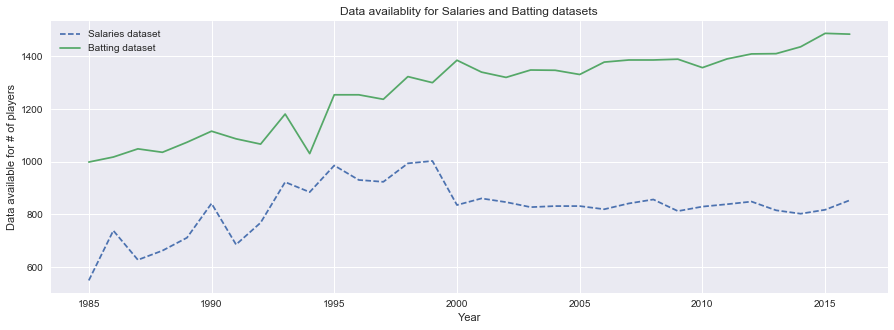

In [13]:
# Create data grouped by year and team
def grouped_data(data):
    # Count number of entries per year and per team
    grouped = data.groupby(['yearID','teamID'], as_index=False).count()\
        [['yearID','teamID','playerID']]
    return grouped

# Count total number of salaries and batting entries per year
sum_salaries = grouped_data(salaries_teams_adj).groupby('yearID', as_index=False).sum()
sum_batting = grouped_data(batting_1985).groupby('yearID', as_index=False).sum()

# Create line plot
def create_2lineplot(data1, data2, col, lab1, lab2, title, ylabel):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    x = data1['yearID']
    y1 = data1[col]
    y2 = data2[col]
    plt.plot(x,y1,'--', label = lab1)
    plt.plot(x,y2,'-', label = lab2)
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    
create_2lineplot(sum_salaries, sum_batting, 'playerID', 'Salaries dataset', 'Batting dataset',\
                 'Data availablity for Salaries and Batting datasets','Data available for # of players')

<p>When exploring the salaries data more closely, it becomes clear that the average number of salaries per team lies for most years between 25 and 30 which is lower than expected based on teams having a roster between 25 and 40 players (plus higher for midseason transfers). There is also a big variance of number of salaries available per team per year. It is therefore impossible to make any conclusions about MLB budgets in general due to the variance in available data and missing data.</p>

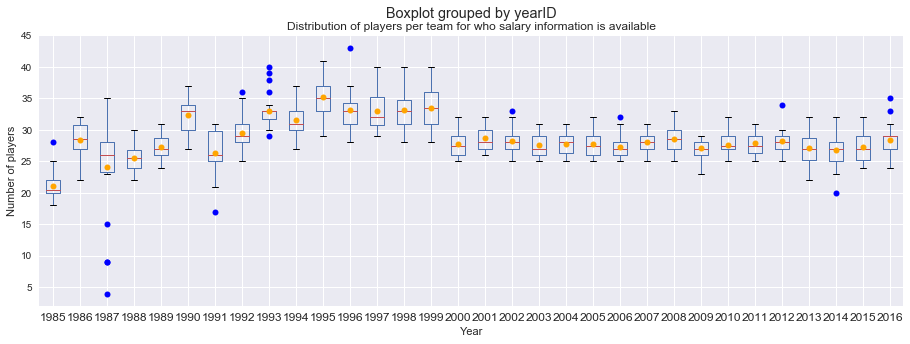

In [14]:
# Creating boxplot  
def create_boxplot(x1,y1, xlabel, ylabel, title, data):        
    meanpointprops = dict(marker='o', markerfacecolor='orange')
    data.boxplot(column = y1, by= x1, figsize=(15,5), sym='bo', showmeans=True, 
                 meanprops=meanpointprops)
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
create_boxplot('yearID', 'playerID', 'Year', 'Number of players', \
               'Distribution of players per team for who salary information is available', grouped_data(salaries_teams_adj))

<h4>Top 20 salaries</h4>
<p>As we want to compare team budgets, it is decided to take only the top 20 salaries per team per year into account. By taking the top 20 salaries, at least the highest available salaries will be taken into account. As can be seen from the bar chart below, teams spent on average at least 30% of their budget on their top 3 players. Further 9,346 of the 26,380 real salaries were 500,000 USD or less. Therefore it seems to be reasonable to take the top 20 salaries into account. As the budgets will be calculated based on the same number of players per team regardless how many salaries are available it makes that the budgets are more comparable.</p>

In [15]:
print (len(salaries_teams_adj[salaries_teams_adj.real_salary<500001]), len(salaries_teams_adj))

(9346, 26380)


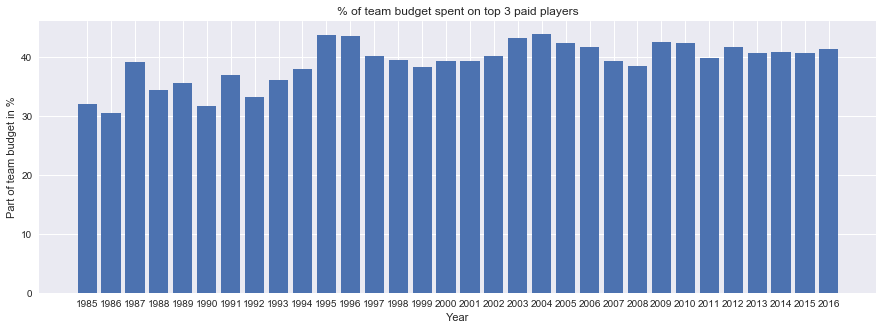

In [16]:
# Get three top salaries
def three_largest(df,n=3,column='real_salary'):
    return df.sort_values(by=column)[-n:]

# Top 3 salaries per team per year
top3 = salaries_teams_adj.groupby(['yearID','teamID'],as_index=False).apply(three_largest)

# Sum of top 3 salaries per team per year
top3_sum = top3.groupby(['yearID','teamID'], as_index=False).sum()[['yearID','teamID','real_salary']]

# Team budgets per year
budgets = salaries_teams_adj.groupby(['yearID','teamID'], as_index=False).sum()[['yearID','teamID','real_salary']]

# Merge top 3 budgets with yearly team budgets
tops = top3_sum.merge(budgets, on=['yearID','teamID'], how='left')

# Add column that display the % that of total budget is spent on the top 3 paid players
tops['top3'] = ((tops['real_salary_x'] / tops['real_salary_y']) * 100)

# Find the mean % per year
tops_mean = tops.groupby('yearID', as_index=False).mean()

# Create bar chart
def create_chart(data, col, type, title, ylabel, showing):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)

    x = range(len(data))
    y = data[col]
    labels = data['yearID']
    if type=='plot':
        plt.plot(x,y)
    elif type=='bar':
        plt.bar(x,y)

    plt.xticks(x, labels)
    plt.ticklabel_format(style='plain', axis='y')

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)

    # annotations
    if showing:
        ax.annotate('crisis 1990-1991', xy=(4.5, 35000000),  xytext=((2.75, 58000000)), 
                    xycoords='data',arrowprops=dict(facecolor='green',arrowstyle="simple"))
        ax.annotate('crisis 2001', xy=(15, 85361622.92),  xytext=((13.9, 105000000)), 
                    xycoords='data',arrowprops=dict(facecolor='green',arrowstyle="simple"))
        ax.annotate('crisis 2007-2009', xy=(22.5, 95900000),  xytext=((20.75, 75000000)), 
                    xycoords='data',arrowprops=dict(facecolor='green',arrowstyle="simple"))
        ax.annotate('MLB strike 1994-1995', xy=(8.5, 50800000),  xytext=((6.2, 75000000)), 
                    xycoords='data',arrowprops=dict(facecolor='green',arrowstyle="simple"))
    plt.show()

create_chart(tops_mean, 'top3', 'bar', '% of team budget spent on top 3 paid players', 'Part of team budget in %', False)

<p>For 19 teams there are 20 or less salaries available for a year. The boxplot above showed that for 1985 the average number of salaries available is close to 20, for 13 teams in that year 20 salaries or less are available. It is therefore decided to drop 1985 from the analysis. Further we drop 4 teams for 1987, 1 for 1991 and 1 for 2014. These teams are also visible in the boxplot as the blue outliers on the low end. By dropping these entries, we are left with 25,757 salaries.</p>

In [17]:
# Find teams for which 20 or less salaries are available
grouped_salaries = grouped_data(salaries_teams_adj)

group_less_20 = grouped_salaries[grouped_salaries.playerID<=20]
print group_less_20.groupby('yearID', as_index=False).count()[['yearID', 'teamID']].to_string(index=False)

# Drop all 1985 data
salaries_teams_adj2 = salaries_teams_adj[salaries_teams_adj.yearID>1985]

# Drop other players from teams for which less than 20 players' salaries are available 
to_drop = ['1987_BOS_AL','1987_MIN_AL','1987_SEA_AL','1987_TEX_AL','1991_MON_NL','2014_HOU_AL']
salaries_complete = salaries_teams_adj2[~(salaries_teams_adj2.new.isin(to_drop))]

print ''
print 'Number of salaries:' ,len(salaries_complete)
print 'Number of teams:', len(salaries_complete.groupby('teamID').count())

yearID  teamID
  1985      13
  1987       4
  1991       1
  2014       1

Number of salaries: 25757
Number of teams: 35


In [18]:
# Get top 20 salaries
def largest(df,n=20,column='real_salary'):
    return df.sort_values(by=column)[-n:]

# Applied to salaries_complete dataset
top20 = salaries_complete.groupby(['yearID','teamID'],as_index=False).apply(largest)

# Fill missing data with 'na' (=not available) so that we do not lose the data for 1994
top20 = top20.fillna('na')

# Sum the top 20 salaries per team per year
top20_total = top20.groupby(['yearID','teamID','lgID','attendance','LgWin','WSWin'],as_index=False).sum()\
    [['yearID','teamID','lgID','real_salary','attendance','LgWin','WSWin']] 

<h3>Team budgets</h3>
<p><b>Note:</b> All observations and conclusions are only valid for this dataset, which is limited: 
<ol>
<li>Only looking at the timeperiod 1986-2016 (excl. 1994 for some analysis).</li>
<li>Only looking at the top 20 <b>available</b> salaries per team per year. There is no certainity about missing or incorrect salaries.</li>
<li>Other omissions or incorrect data in other datasets could be present that we are not aware of. Where incorrect data was spotted, corrections have been made or entries have been dropped but there are no certainties about the overall value of the data.</li>
</ol>
<p>In the boxplot chart below you can see that the average corrected real team budget (yellow dots) has increased from 24,4 mln. in 1986 to 120,5 mln. in 2016. The variability in the budgets has grown over time as the size of the boxes show (have become wider). Since 2002 the mean is also higher than the median meaning that the distribution of the budgets has become more right skewed (most budgets are in the lower part of the scale with some significant higher budgets for a few clubs). This is also caused as a top outlier appears (blue dots) starting in 2003, which is the New York Yankees team for most years.</p> 

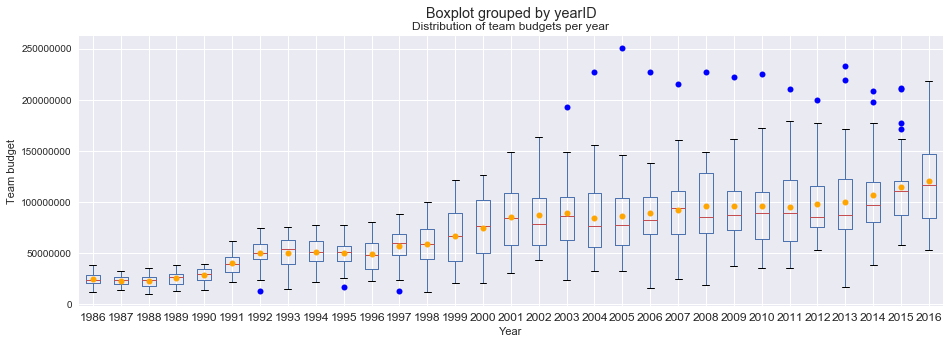

In [19]:
# Create boxplot of top 20 salaries per team
create_boxplot('yearID','real_salary','Year','Team budget', 'Distribution of team budgets per year',top20_total)

In [20]:
# Show average budgets in 1986 and in 2016
mean_budget = top20_total.groupby('yearID', as_index=False).mean()[['yearID','real_salary']]
mean1986_2016 = mean_budget[(mean_budget.yearID == 1986) | (mean_budget.yearID == 2016)][['yearID','real_salary']]
print mean1986_2016.rename(columns={'yearID':'Year', 'real_salary': 'Average team budget'}).to_string(index=False)

Year  Average team budget
1986          24380302.71
2016         120468385.63


<h4>Team budgets over time</h4>
<p>If we look at the average budgets over time combined with information when <a href="https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States">economic crises</a> took place, we see that growth of the average budgets slows down and even decreases after periods of economic crisis. In 1994-1995 there was a <a href="https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike">players' strike</a> which probably influenced the willingness of MLB club owners to increase their budgets in the first years after. We also should keep in mind that we are looking at a dataset that is incomplete and only focus on the top 20 available salaries per team.</p> 

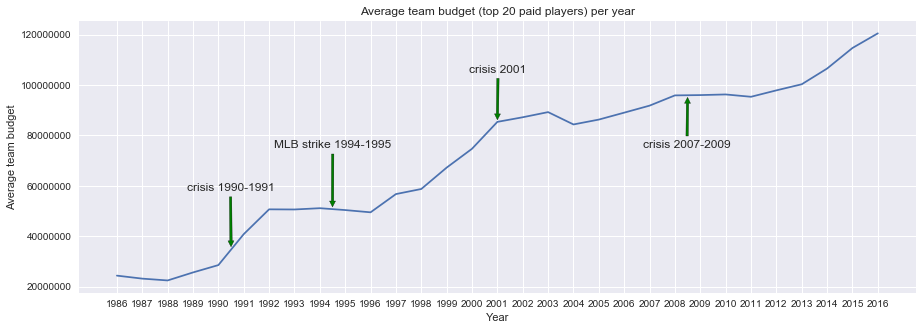

In [21]:
# Find index and values for economic crises
crisis_years = mean_budget[(mean_budget.yearID==[1990]) |(mean_budget.yearID==[1991]) | # crisis 7/1990 - 3/1991
                    (mean_budget.yearID==[2001]) | # 3-11/2011
                    (mean_budget.yearID==[2008]) | (mean_budget.yearID==[2009])] # 12/2007 - 06/2009 

#Find index and values for MLB strike
strike_years = mean_budget[(mean_budget.yearID==[1994]) | (mean_budget.yearID==[1995])] # MLB strike 

# Create line chart
create_chart(mean_budget,'real_salary','plot', "Average team budget (top 20 paid players) per year", \
             "Average team budget", True)   

<h4>Budgets for AL and NL teams</h4>
<p>Budgets in both leagues follow the same development over the years. Except that since 1989 the avarea team budgets are in general higher in the AL League. When looking at the highest 5 budgets per year, most years 60 or 80% of these budgest are for AL teams and when looking at the highest budget for 27 years it is an AL team. In the first half of 2000 the difference is becoming bigger between two leagues, with significantly higher budgets for the New York Yankees which we can be observed in the scatterplot below. (The higher NYY budgets coincides with <a href="https://en.wikipedia.org/wiki/Alex_Rodriguez">Alex Rodriguez</a> joining the team in 2004 and being one of the <a href="https://en.wikipedia.org/wiki/List_of_highest_paid_Major_League_Baseball_players#Salary_progressionhttps://en.wikipedia.org/wiki/List_of_highest_paid_Major_League_Baseball_players#Salary_progression">best paid players</a> in MLB.) New York Yankees have had the highest budget 20 of the 31 years in this dataste. Only since 2010 the NL budgets seems to catch up with the AL ones as do the other NL teams with the New York Yankees.</p>

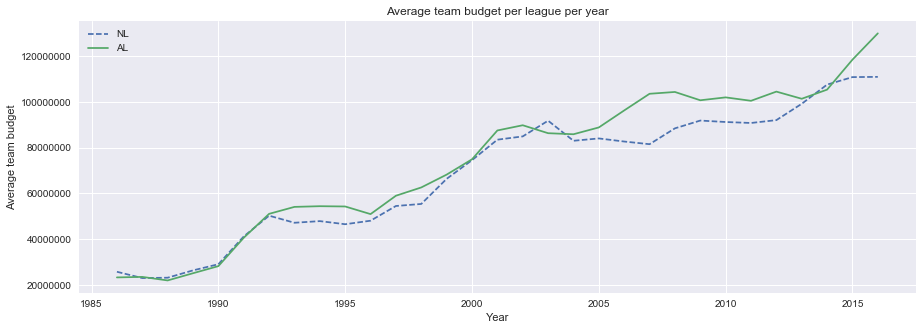

In [22]:
# Group salary data by legaue
mean_league = top20_total.groupby(['yearID','lgID'], as_index=False).mean()

# Create two subgroups
mean_NL = mean_league[mean_league.lgID=='NL']
mean_AL = mean_league[mean_league.lgID=='AL']

create_2lineplot(mean_NL, mean_AL, 'real_salary','NL', 'AL', 'Average team budget per league per year',\
                 'Average team budget')

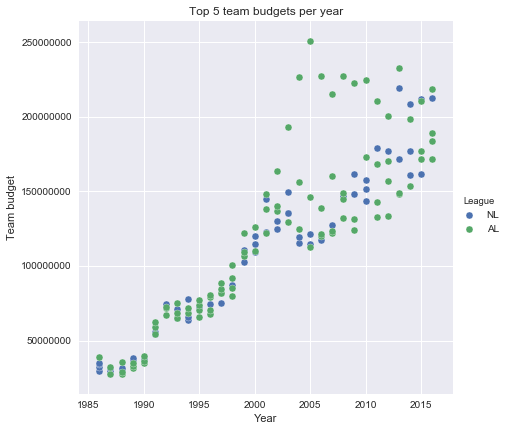

In [23]:
# Get five top team budgets per year
def five_largest(df,n=5,column='real_salary'):
    return df.sort_values(by=column)[-n:]

top_budgets = top20_total.groupby('yearID', as_index=False).apply(five_largest)

# Rename columns
top_scatter = top_budgets.rename(index=str, columns={"lgID":"League","yearID": "Year", 'real_salary':'Team budget'}) 

# Create scatterplot of top 5 budgets
def colored_scatterplot(data,x,y,hue, title):
    sns.pairplot(x_vars=x, y_vars=y, data=data, hue=hue, size=6)
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(title)
    plt.show()    

colored_scatterplot(top_scatter, x="Year", y='Team budget', hue='League', title='Top 5 team budgets per year')

In [24]:
# Highest budgets by team
highest_budget = (top_budgets.groupby(['yearID'], as_index=False)['real_salary'].max())\
    .merge(top_budgets, on=['yearID','real_salary'], how='left')
highest_budget = highest_budget.groupby('teamID', as_index=False).count()\
    [['teamID','yearID']].sort_values('yearID', ascending=False)

print (highest_budget.merge(teamid_name, on='teamID', how='left').iloc[:,[3,2,1]]).\
    rename(index=str, columns={'lgID':'League','name':'Team name', 'yearID':'# of highest yearly budgets'}).to_string(index=False)

League            Team name  # of highest yearly budgets
   AL     New York Yankees                           20
   NL  Los Angeles Dodgers                            3
   AL    Baltimore Orioles                            2
   AL    Toronto Blue Jays                            2
   NL       Atlanta Braves                            1
   AL   Kansas City Royals                            1
   NL        New York Mets                            1
   AL    Oakland Athletics                            1


<h4>Experience vs budgets</h4>
<p>Teams that have more experienced players on their are expected to have higher team budgets, as more experienced players are earning more (just with all jobs, seniors are in general paid more than juniors). This is especially true for the MLB as steep payraises occur when players become free agents, which happens in general after <a href="https://www.forbes.com/sites/kurtbadenhausen/2016/04/07/average-baseball-salary-up-20700-since-first-cba-in-1968/#55f081f73e48">6 years</a> of playing. It can however also be argued that teams with more financial means, can attract well-performing players and decision of buying players is based on the performance of these players in the past.<br><br>
There is moderate positive correlation (correlation coefficient = 0.45.) between the total team experience and the team budget. However we know from charts above that the team budgets have increased over time even when corrected for inflation. So when looking at the three decades of this dataset individually, we see that for the last 2 decades the correlation is even higher, namely 0.74 (1997-2006) and 0.64 (2007-2016). Meaning that high team budgets and experienced teams go hand in hand.</p> 

In [25]:
# Get sum of salaries and experience in years per team per year
top20_scatter = top20.groupby(['yearID','teamID','attendance'], as_index=False).sum()\
    [['yearID','teamID','attendance','real_salary','experience']]

top20_scatter['Time period'] = pd.cut(top20_scatter['yearID'], [1985,1996,2006,2016],\
                     labels=['1986-1996','1997-2006','2007-2016'])

# Rename columns
top20_scatter = top20_scatter.rename(index=str, columns={"attendance":"Home attendance", \
                                    "experience": "Team experience (in years)", 'real_salary':'Team budget'})  

# Calculate Pearson correlation coefficient
def correlation(data, variable):
    x = data[variable]
    y = data['Team budget']

    x1 = data[data.yearID<1997][variable]
    y1 = data[data.yearID<1997]['Team budget']

    x2 = data[(data.yearID>1996) & (data.yearID<2007)][variable]
    y2 = data[(data.yearID>1996) & (data.yearID<2007)]['Team budget']

    x3 = data[data.yearID>2006][variable]
    y3 = data[data.yearID>2006]['Team budget']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print "Correlation coefficient (dataset)  :", "%0.2f" % r_value
    slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)
    print "Correlation coefficient (1986-1996):", "%0.2f" % r_value
    slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)
    print "Correlation coefficient (1997-2006):", "%0.2f" % r_value
    slope, intercept, r_value, p_value, std_err = stats.linregress(x3, y3)
    print "Correlation coefficient (2007-2016):", "%0.2f" % r_value

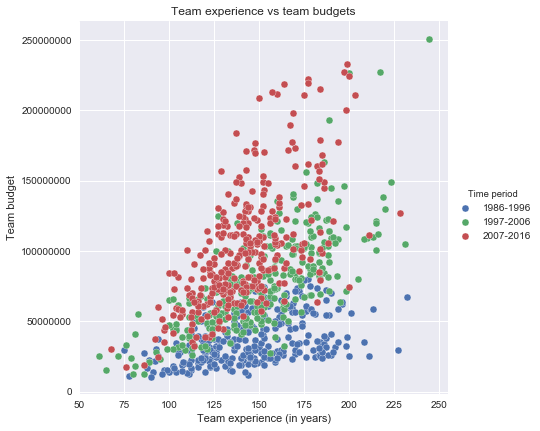

Correlation coefficient (dataset)  : 0.45
Correlation coefficient (1986-1996): 0.40
Correlation coefficient (1997-2006): 0.74
Correlation coefficient (2007-2016): 0.64


In [26]:
colored_scatterplot(top20_scatter, x="Team experience (in years)", y='Team budget', hue='Time period', title='Team experience vs team budgets')
correlation(top20_scatter, variable='Team experience (in years)')

<h4>Attendance vs budgets</h4>
<p>One might expect that teams with higher budgets have better players and therefore attract bigger audiences. It could also be argued that teams with higher attendance, have more revenue from tickets sales and merchandise which means they have more financial means to spend on their teams. As can be seen below, there is indeed a positive correlation (of 0.62) between team budgets and home attendance. Also here we see that this correlation has become much stronger in the last two decades 0.71 (1997-2006) and 0.73 (2007-2016) than in the first decade 0.29 (1986-1996).</p> 

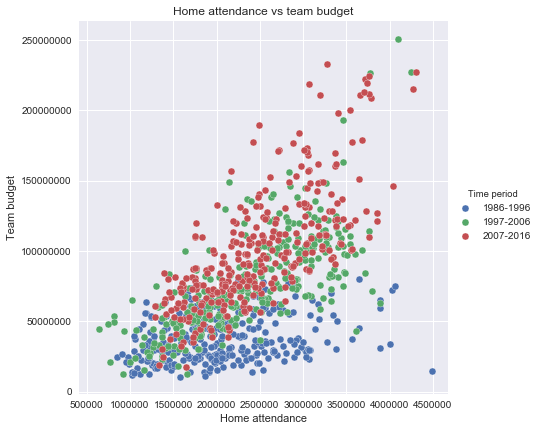

Correlation coefficient (dataset)  : 0.62
Correlation coefficient (1986-1996): 0.29
Correlation coefficient (1997-2006): 0.71
Correlation coefficient (2007-2016): 0.73


In [27]:
colored_scatterplot(top20_scatter, x="Home attendance", y='Team budget', hue='Time period', title='Home attendance vs team budget')
correlation(top20_scatter, variable='Home attendance')

<h4>Winners vs non-winners</h4>
<p>In other sports (European soccer) the teams with high budgets are also the ones that win the prizes. Is this also true for MLB teams?<br>
<p>As no post season was played in 1994 due to the strike, 1994 is not taken into account when performing these statistic tests as there were no league or World Series winners.</p>

In [28]:
# Remove 1994 data
top20_wo1994 = top20_total[top20_total.yearID!=1994]

<h5>World Series</h5>
<p>In the 3 decades of this dataset, there have been 18 different teams that have become World Champion. 17 teams  did not win the World Series. New York Yankees is the team with the most World Series wins (5) in this period. 5 other teams became World Champion at least once. The last winner were the Chicago Cubs.</p>

In [29]:
def winners_teams(x,top, champion):
    # Find unique winners
    winners = top20_wo1994[top20_wo1994[x]=='Y'].groupby('teamID', as_index=False).count()[['teamID','yearID']]
    print "Teams that have won the "+ champion + ":", len(winners)

    # Last winner
    if x=="WSWin":
        print "Last winner:", (top20_wo1994[(top20_wo1994[x]=='Y')&(top20_wo1994.yearID==2016)]\
                               .merge(teamid_name, on='teamID', how='left'))['name'].ix[0]
    else:
        print "Last winners (AL/NL):",\
        (top20_wo1994[(top20_wo1994[x]=='Y')&(top20_wo1994.yearID==2016)&(top20_wo1994.lgID=="AL")]\
            .merge(teamid_name, on='teamID', how='left'))['name'].ix[0], "/", \
        (top20_wo1994[(top20_wo1994.LgWin=="Y")&(top20_wo1994.yearID==2016)&(top20_wo1994.lgID=="NL")]\
            .merge(teamid_name, on='teamID', how='left'))['name'].ix[0]

    # Top of list of winners with at least 1 win
    winners_all = winners.merge(teamid_name, on='teamID', how='left')

    print ""
    print winners_all.rename(index=str, columns={"name":"Team", "yearID": "# of wins"}).\
        sort_values("# of wins", ascending=False).reset_index(drop=True).iloc[:,[2,1]].head(top).to_string(index=False)

# WS winners
winners_teams('WSWin',6, "World Series")

Teams that have won the World Series: 18
Last winner: Chicago Cubs

Team  # of wins
    New York Yankees          5
      Boston Red Sox          3
San Francisco Giants          3
   Toronto Blue Jays          2
 St. Louis Cardinals          2
     Florida Marlins          2


<p>We want to see if the distributions of the team budgets of World Series winners and non-winners are similar. As the distributions are not normally distributed we cannot use the t-test. We therefore use the <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>. This is a nonparametric test which tests that it is equally likely that a randomly selected team budget from the World Series winners will be greater than a randomly selected team budget from the non-winners. Note that we define winners as teams that won the World Series at least once, non-winners are teams that never won the World Series between 1986 and 2016. As it seems that winning the World Series will have an effect on future budgets as well.<br>
<br>
H<sub>0</sub>: D<sub>1</sub> and D<sub>2</sub> are identical<br>
H<sub>a</sub>: D<sub>1</sub> is shifted to the right of D<sub>2</sub><br>
<br>
where H<sub>0</sub> is the null hypothesis, H<sub>a</sub> is the alternative hypothesis. D<sub>1</sub> is the probability distribution for winners, D<sub>2</sub> is the probability distribution of the non-winners.<br>
<br>
As we look at the distributions we report the median team budgets, which for winners was 71,6 million and for non-winners 63,0 million. The distributions in the two groups differed significantly, we can therefore conclude that winners budgets exceed the non-winners budgets for this dataset (Mann–Whitney U = 74,920, n_winners = 493,  n_non_winners = 365, P < 0.01 one-tailed).<br><br>
The boxplot chart also shows that the distribution of team budgets for winners lies to the right of the distribution of non-winners. For the winners, there are multiple budgets that are regarded as outliers. It was kind of what we expected as we have seen that highest budgets came from the New York Yankees who also won the World Series 5 times.</p>

In [30]:
def winner_stats(var1, var2):
    all_winners = top20_wo1994[top20_wo1994[var1]=='Y'].groupby('teamID', as_index=False).count()['teamID'].tolist()

    # Add column to dataset which indicates if a team ever won (Y/N)
    top20_wo1994[var2] = top20_wo1994['teamID'].isin(all_winners)
    top20_winners = top20_wo1994

    # Get data for winners and non-winners
    x = top20_winners.loc[top20_winners[var2] == True, 'real_salary']
    y = top20_winners.loc[top20_winners[var2] == False, 'real_salary']

    # Find median for both groups
    print "Median budget (winners, non-winners):", (x.median(), y.median())

    # Mann Whitney results
    print "Winners / non-winners:", (len(x), len(y))
    statistic, pvalue = scipy.stats.ranksums(x, y)
    print "P-value:", "%0.2f" % pvalue
    statistic, pvalue = scipy.stats.mannwhitneyu(x,y)
    print "U:", statistic

winner_stats('WSWin',"Winner")

Median budget (winners, non-winners): (71627363.67173618, 63029826.8526181)
Winners / non-winners: (493, 365)
P-value: 0.00
U: 74920.0


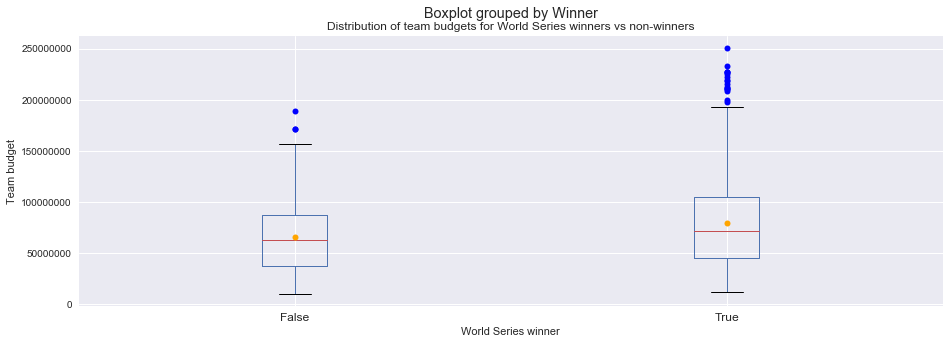

In [31]:
create_boxplot('Winner','real_salary','World Series winner','Team budget', \
               'Distribution of team budgets for World Series winners vs non-winners', top20_wo1994)

<h5>AL and NL</h5>
<p>25 teams were at least once the best in the regular season and won their league. Last year's league winners were the Cleveland Indians (AL) and the Chicago Cubs (NL). In the AL, the New York Yankees have won the regular season the most times (7). In the NL three teams all won their legaue 5 times. 

In [32]:
# League winners
winners_teams("LgWin", 4, "league")

Teams that have won the league: 25
Last winners (AL/NL): Cleveland Indians / Chicago Cubs

Team  # of wins
    New York Yankees          7
      Atlanta Braves          5
 St. Louis Cardinals          5
San Francisco Giants          5


<p>We also want to see if the distributions of the team budgets of league winners and non-winners are similar. Note that we define winners as teams that won their league at least once, non-winners are teams that never won their league between 1986 and 2016.<br>
<br>
H<sub>0</sub>: D<sub>1</sub> and D<sub>2</sub> are identical<br>
H<sub>a</sub>: D<sub>1</sub> is shifted to the right of D<sub>2</sub><br>
<br>
where H<sub>0</sub> is the null hypothesis, H<sub>a</sub> is the alternative hypothesis. D<sub>1</sub> is the probability distribution for winners, D<sub>2</sub> is the probability distribution of the non-winners.<br>
<br>
Median team budgets for winners and non-winners were 69,3 million and 58,8 million respectively. The distributions in the two groups differed significantly, we can therefore conclude that winners budgets exceed the non-winners budgets (Mann–Whitney U = 50,757, n_winners = 683,  n_non_winners = 175, P < 0.01 one-tailed).<br><br>
From the boxplot it is also visible that for this dataset the distribution of team budgets for league winners lies to the right of the distribution of non-winners. Also for the league winners, there are multiple budgets that are regarded as outliers.</p>

In [33]:
winner_stats('LgWin',"Winner")

Median budget (winners, non-winners): (69285376.71692957, 58801563.73508404)
Winners / non-winners: (683, 175)
P-value: 0.00
U: 50757.0


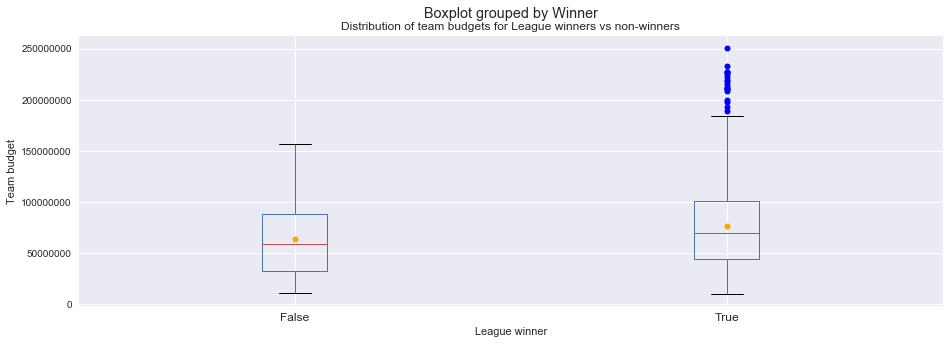

In [34]:
create_boxplot('Winner','real_salary','League winner','Team budget', \
               'Distribution of team budgets for League winners vs non-winners',top20_wo1994)

<h3>Conclusions</h3>
<p>For this dataset:
<ol>
<li>the average team budget (corrected for inflation) has increased by a factor 5 between 1986 and 2016. The growth in budgets became steady or even decreased after years there was an economic crisis.</li>
<li>the gap in budgets between the two leagues has widened since mid 2000s, due to higher increases in budgets in the AL league (mostly caused by higher budgets for the New York Yankees). Since 2010 the NL is catching up.</li>
<li>higher team budgets tend to correlate highly with more experienced teams (in years), especially in the last two decades. </li>
<li>higher team budgets also tend to correlate highly with higher home attendance. For both nothing can be said about causation. As higher team budgets can lead to buying more experienced players which in turn can lead to more attendance. Higher attendance and more experienced players can also lead to more sales (tickets, merchandise) which leads to higher available budgets. Especially for this dataset one should keep in mind that team budgets are only based on the top 20 salaries available and that there has been an increase in team budgets since 1986. Higher attendance can also just be caused by increased populations over time and as we only look at 3 decades of data we might find other results for experience vs team budgets. It would be interesting to explore how the free agent system impacted salary development, if before more experience players earned more than less experienced players and if they experienced a spike after an <i>x</i> number of years.</li>
<li>winners (either league or World Series) have significantly higher budgets that non-winners. Winners are defined as teams that won their league or the World Series at least once in this timeperiod.</li>
</ol>

<h4>Future research</h4>
<p>It would be interesting to further explore for which players there is salary data available. Are these players the ones that play the most games, play a certain position, hit the most homeruns or make most points? Which players are missing?<br>
As baseball is not as big in other countries than in the US it would be interesting to see if there is a difference in salaries between players who were born in the US and abroad (=meaning rest of the world). And additonal if there is a difference in salary for non-US players who played college baseball and the ones that did not?</p>

<h3>Sources</h3>
<p>Next to the links in the text, I have also made use of:
<ul>
<li>"Python for Data Analysis" by McKinney</li>
<li>"Statistics for Business and Economics" by McClave, Benson and Sincich</li>
<li>Stackoverflow and Udacity forums</li>
<li>Python, matplotlib and seaborn sites</li>
</ul>